# mRNA 데이터를 활용한 암종류 예측하기 (TensorFlow 활용)
## - 전체 데이터와 차원축소(dimension shrinkage) 기법 활용

## 마이크로어레이와 관련된 문제점 

* 마이크로어레이 기술이 발달하면서 대용량 유전체 데이터에 대한 분석이 유전체 및 생물정보학 연구에서 중요한 주제로 자리잡기 시작하였다.변수의 종류가 상대적으로 제한적이고 시료의 수가 많던 기존의 데이터 형태에서 변수의 양이 기하급수적으로 늘어난 고차원 데이터(high-dimensional data)의 형태로 바뀌면서 기존의 통계분석 방법론을 곧바로 적용하는 것이 어렵게 되었다. 그 결과, 마이크로어레이 데이터에 적합한 고유의 방법론들이 계속해서 등장하였다.

* 마이크로어레이 데이터는 암진단에서 활용가능하다. 예를 들어, 회귀모형과 유전체 정보를 바탕으로 개인의 발암 여부를 예측할 수 있다. 이러한 회귀분석에서 나타나는 문제점은 변수의 수가 데이터의 수보다 많아 회귀계수의 추정이 불가능하다는 점이다.

### 주성분 분석(PCA: Principal Component Analyis)
* 차원 축소의 대표적인 기법이다. 주성분 분석이란, 여러 개의 변수들로 이루어진 다변량 자료에 대하여 서로 독립적인 주(요) 성분을 도출하여 원래 변수들이 가지고 있는 변이(정보)를 축약하고, 다변량 변이의 구조를 분석하는 방법을 말한다. 통계분석과정에서 관련 변수가 많은 경우 효과적으로 변수의 수를 줄일 수 있으면 유용한 분석을 실시할 수 있다.
* 주성분 분석은 원래 변수들을 선형결합의 형식으로 변환시켜 주성분이라고 부르는 서로 상관되어 있지 않은(독립적인) 인공적 변수들을 유도한다. 여기서 각 주성분들이 가지는 변이(정보)의 크기(주성분의 분산)을 기준으로 그 중요도의 순서를 생각할 때, 처음 몇 개의 주성분이 원래 자료가 가지고 있는 총 변이(총 정보)의 가능한 많은 부분을 보유하도록 함으로써 차원의 축약을 기할 수 있게 된다.

## 1. 데이터 준비 및 변수의 차원 축소

In [1]:
get_ipython().magic(u'matplotlib inline')
from datetime import datetime
import time
import os
from pprint import pprint
import numpy as np
import gzip, cPickle
from glob import glob
import timeit
import sys
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
import tensorflow as tf

In [2]:
os.chdir('/Users/joikyeon/Documents/BigBio/mRNA')
os.getcwd()

'/Users/joikyeon/Documents/BigBio/mRNA'

In [3]:
def dir_to_dataset(glob_files):
    for file_count, file_name in enumerate(sorted(glob(glob_files)) ):
        print(file_name)
        pklPartial=gzip.open(file_name)
        pklT= cPickle.load(pklPartial)
        if file_count==0:
            dataSet0=pklT[0]
            dataSet1=pklT[1]
        else:
            dataSet0 = np.concatenate((dataSet0,pklT[0]))
            dataSet1 = np.append(dataSet1,pklT[1])
        pklPartial.close()
        print len(dataSet0), len(dataSet1) 

    dataSet1=dataSet1-1
    #print np.amax(dataSet1)
    dataSet= (dataSet0, dataSet1)
    return dataSet

In [4]:
# 위의 함수를 이용하여 train data를 merge함.
dataSets = dir_to_dataset('*type1*')

mrna_20160125-200855_type1_00.pkl.gz
500 500
mrna_20160125-200855_type1_01.pkl.gz
1000 1000
mrna_20160125-200855_type1_02.pkl.gz
1500 1500
mrna_20160125-200855_type1_03.pkl.gz
2000 2000
mrna_20160125-200855_type1_04.pkl.gz
2500 2500
mrna_20160125-200855_type1_05.pkl.gz
3000 3000
mrna_20160125-200855_type1_06.pkl.gz
3500 3500
mrna_20160125-200855_type1_07.pkl.gz
4000 4000
mrna_20160125-200855_type1_08.pkl.gz
4500 4500
mrna_20160125-200855_type1_09.pkl.gz
5000 5000
mrna_20160125-200855_type1_10.pkl.gz
5500 5500
mrna_20160125-200855_type1_11.pkl.gz
6000 6000
mrna_20160125-200855_type1_12.pkl.gz
6500 6500
mrna_20160125-200855_type1_13.pkl.gz
7000 7000
mrna_20160125-200855_type1_14.pkl.gz
7500 7500
mrna_20160125-200855_type1_15.pkl.gz
7945 7945


In [5]:
# feature와 label을 구분
X, Y = dataSets

In [6]:
# feature와 label의 차원을 확인
print X.shape ; print Y.shape

(7945, 20502)
(7945,)


In [7]:
# 주성분 분석(PCA)을 통해 차원 축소 (2차원으로)
pca=PCA(n_components=2)

pX= pca.fit(X).transform(X)

In [14]:
print(pca.explained_variance_ratio_)

[ 0.34524007  0.07136942]


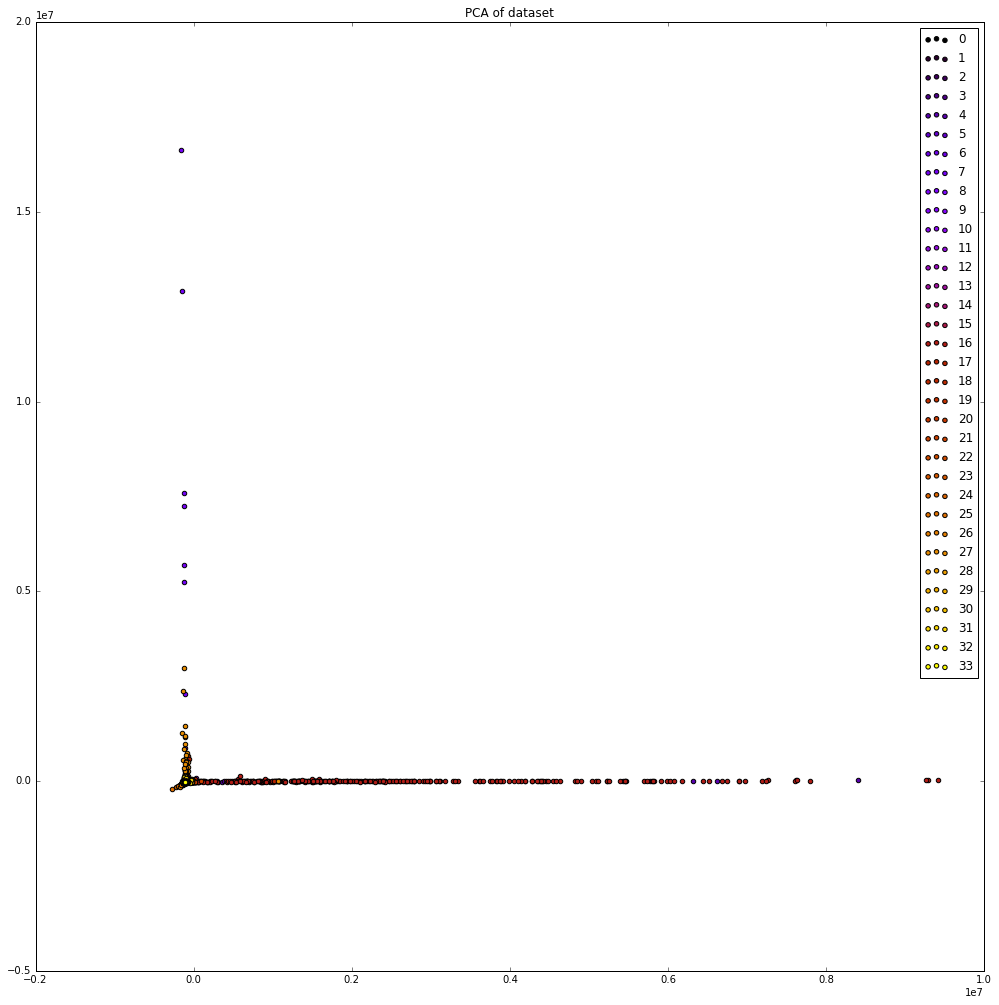

In [11]:
number = 34
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, number)]


plt.figure(figsize=(17,17))
for i, c in enumerate(colors):
    plt.scatter(pX[Y == i, 0], pX[Y == i, 1], c=c, label=i)
plt.title('PCA of dataset')
plt.legend()
plt.show()

## 2. TensorFlow 활용하기

## 1) 모형 훈련시키기

In [16]:
print pX.shape
print X.shape
print Y.shape

(7945, 2)
(7945, 20502)
(7945,)


In [17]:
train_x=pX
train_y=Y

In [18]:
import pandas as pd
print(pd.get_dummies(train_y).values)
train_y_onehot=pd.get_dummies(train_y).values

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [19]:
train_y_onehot.shape

(7945, 34)

In [20]:
bias=np.ones((train_x.shape[0],1))
bias.shape

(7945, 1)

In [22]:
train_x_final=np.hstack((bias,train_x))
print train_x_final.shape

(7945, 3)


In [36]:
x_data=train_x_final
y_data=train_y_onehot

In [37]:
X=tf.placeholder("float", [None,3]) 
Y=tf.placeholder("float", [None,34])

In [38]:
# 모델의 가중치(weight) 설정
W=tf.Variable(tf.zeros([3,34]))

In [42]:
# 모델 구축
hypothesis=tf.nn.softmax(tf.matmul(X,W))

In [43]:
# learning rate
learning_rate=0.01

In [44]:
# cross entropy cost function 세팅
cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(hypothesis), reduction_indices=[1]))

In [45]:
# Gradient Descent
optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [46]:
# 변수 초기화(Initialize variable)
init=tf.initialize_all_variables()

In [49]:
# Launch the Graph
with tf.Session() as sess:
    sess.run(init)
    
    for step in xrange(2001):
        sess.run(optimizer, feed_dict={X:x_data, Y:y_data})
        if step%200==0:
            print step, sess.run(cost, feed_dict={X:x_data, Y:y_data}), sess.run(W)

0 nan [[ -2.22358140e-04   8.97673599e-05   8.10935919e-04  -2.09909213e-05
   -2.52559053e-04   1.87948623e-04  -2.51301739e-04  -1.20429431e-04
   -2.26132790e-04  -1.40567747e-04   2.06840850e-04  -2.12289815e-04
    2.47123215e-04  -8.40373923e-06  -1.39308788e-04   1.76619578e-04
    8.09560879e-05   2.34534178e-04   1.95503992e-04  -2.17327412e-04
   -2.09904938e-05  -1.31757333e-04  -1.29239255e-04   1.99280359e-04
   -1.36791685e-04  -5.87526883e-05   1.25008315e-04   1.03612867e-04
   -1.55671616e-04   2.11874692e-04  -1.85871031e-04   2.26985663e-04
   -2.42493377e-04  -2.23613053e-04]
 [ -5.86065674e+00  -3.98786926e+01  -1.11381607e+02  -2.96854630e+01
    6.57489395e+01  -5.03753738e+01  -4.13580275e+00  -1.89614906e+01
   -7.23154449e+00  -1.40931654e+01  -6.15021095e+01  -7.77631283e+00
   -4.20060349e+01  -2.27541027e+01  -1.66231575e+01  -4.52409134e+01
    8.87143188e+02  -4.68428345e+01  -5.01945381e+01  -6.68804550e+00
   -2.66233692e+01  -1.46739864e+01  -1.7618404

## 2)  모형의 평가

In [50]:
# 위의 함수를 이용하여 train data를 merge함.
TestSets = dir_to_dataset('*type3*')

mrna_20160125-200855_type3_00.pkl.gz
500 500
mrna_20160125-200855_type3_01.pkl.gz
1000 1000
mrna_20160125-200855_type3_02.pkl.gz
1500 1500
mrna_20160125-200855_type3_03.pkl.gz
1679 1679


### 이하는 동일...